# Explainability maps continuum? 
## DeepTaylor and PatternAttribution for the Triangles and Squares (Rotaion & Scaling) dataset using iNNvestigate 

## Imports

In [71]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")
eutils = imp.load_source("utils", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils.py")

from code import shape_images as shi


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [72]:
# filenames
# data paths
original_data_path = "/home/elena/eStep/XAI/Data/TrianglesAndSquaresRotationScale"

test_data_fname = os.path.join(original_data_path, 'split_npz','test_data.npz')

# loading
test_data = np.load(test_data_fname)

In [73]:
images_test = test_data['images_test']
labels_test = test_data['labels_test']

print("Size of testing data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))

Size of testing data:  (2000, 4096) and labels:  (2000,)


In [74]:
img_rows = 64
img_cols = 64
if K.image_data_format() == 'channels_first':
    images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
print("Size of testing data: ", np.shape(images_test))

Size of testing data:  (2000, 64, 64, 1)


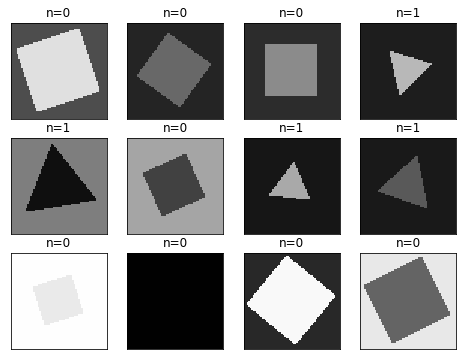

In [75]:
# plot 12 random test images
shi.plot_12images(images_test, labels_test) 

### Labels formatting

In [76]:
# convert class vectors to binary class matrices
labels_test_formatted = np_utils.to_categorical(labels_test, num_classes=2)

print('labels_test_formatted shape:', labels_test_formatted.shape)

labels_test_formatted shape: (2000, 2)


## Model

In [77]:
# filename for model 
model_fname = os.path.join(original_data_path, 'Models','model.h5')

# load the trained model
model = load_model(model_fname) 
print("Loaded model from disk")

Loaded model from disk


Evaluate on test images.

In [78]:
score = model.evaluate(images_test, labels_test_formatted, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

Test loss: 0.10065763419866562
Test accuracy: 97.65 %


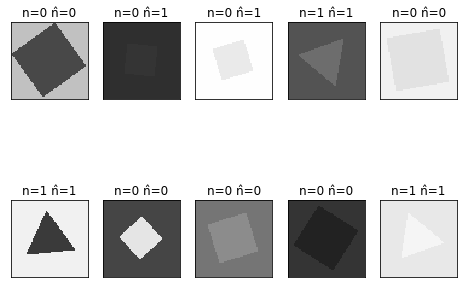

In [79]:
# pick up 10 random images and classify them using the trained model
import matplotlib.cm as cm

figsize = (8, 6)
plt.figure(figsize=figsize)
j=0
nim = len(labels_test)

for _ in range(10):
    ind=int(np.random.randint(1,nim))
    img=images_test[ind,:]
    img=np.reshape(img,(64,64))
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
    label=labels_test[ind]
       
    predictions = model.predict(X);
    pred = np.argmax(predictions) 
    
    j = j+1
    plt.subplot(2, 5, j)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([])
    plt.title('n=%d n̂=%d' % (label, pred))

plt.show()


Determine the indicies of the missclassified images and display some of them.

In [80]:
predictions = model.predict(images_test)
indices_wrong = [i for i,v in enumerate(predictions) if np.argmax(predictions[i])!=np.argmax(labels_test_formatted[i])]
print('Missclassified images: ', len(indices_wrong)/len(labels_test)*100, '%')
images_test_wrong = images_test[indices_wrong]
labels_test_wrong = labels_test[indices_wrong]
print('Number of missclassified images: ', len(indices_wrong))

Missclassified images:  2.35 %
Number of missclassified images:  47


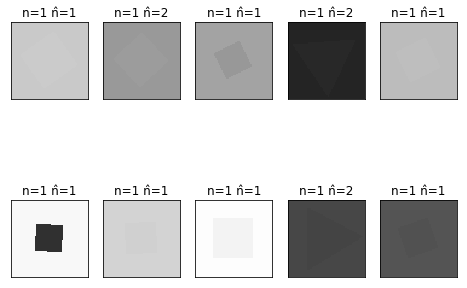

In [81]:
# display the first 10 missclassified images 
figsize = (8, 6)
plt.figure(figsize=figsize)
for ind in range(10):

    img = images_test_wrong[ind].reshape(img_rows, img_cols)
    lab = np.argmax(labels_test_wrong[ind])+1 # we subtracted 1 before
    pred = np.argmax(predictions[ind])+1
    
    plt.subplot(2, 5, ind+1)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([]) 
    plt.title('n=%d n̂=%d' % (lab, pred))

plt.show()

Determine the indicies of the correctly classified images and display some of them.

In [82]:
indices_correct = [i for i,v in enumerate(predictions) if np.argmax(predictions[i])==np.argmax(labels_test_formatted[i])]
print('Correctly classified images: ', len(indices_correct)/len(labels_test)*100, '%')
images_test_correct = images_test[indices_correct]
labels_test_correct = labels_test[indices_correct]
print('Number of correctly classified images: ', len(indices_correct))

Correctly classified images:  97.65 %
Number of correctly classified images:  1953


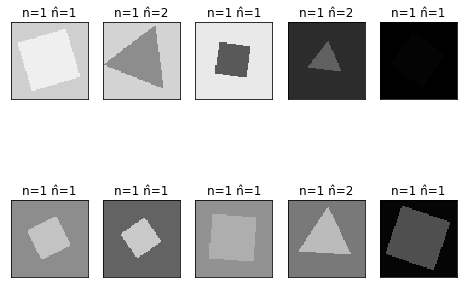

In [83]:
# display the first 10 correctly classified images 
figsize = (8, 6)
plt.figure(figsize=figsize)
for ind in range(10):
      
    img = images_test_correct[ind].reshape(img_rows, img_cols)
    lab = np.argmax(labels_test_correct[ind])+1 # we subtracted 1 before
    pred = np.argmax(predictions[ind])+1
    
    plt.subplot(2, 5, ind+1)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([]) 
    plt.title('n=%d n̂=%d' % (lab, pred))

plt.show()

### Create subsets of images of interest

Split the correctly classified and missclassified images into squares and triangles and sort them on contrast and size. 

There are  971  square shapes in the test set wich have been classified correctly.


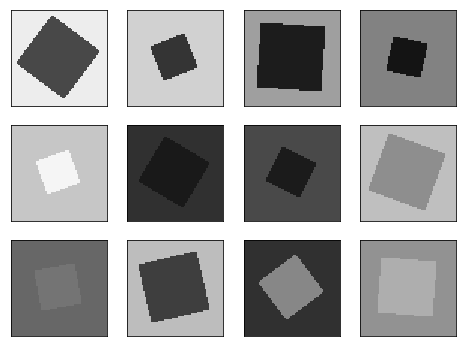

There are  982  triangle shapes in the test set wich have been classified correctly.


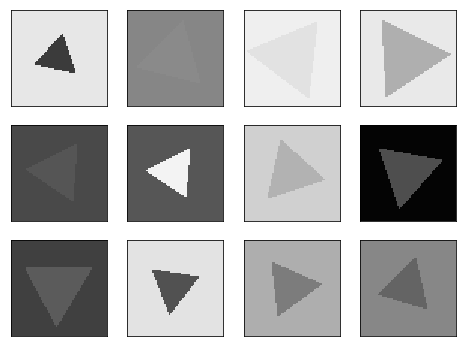

In [84]:
# Split the correct images in squares and triangles

# squares
label = 0

squares_correct = shi.select_shape(images_test_correct, labels_test_correct, label)
print('There are ',np.shape(squares_correct)[0] , ' square shapes in the test set wich have been classified correctly.')

shi.plot_12images(squares_correct)

# triangles
label = 1

triangles_correct = shi.select_shape(images_test_correct, labels_test_correct, label)
print('There are ',np.shape(triangles_correct)[0] , ' triangle shapes in the test set wich have been classified correctly.')

shi.plot_12images(triangles_correct)

There are  41  square shapes in the test set wich have been missclassified.


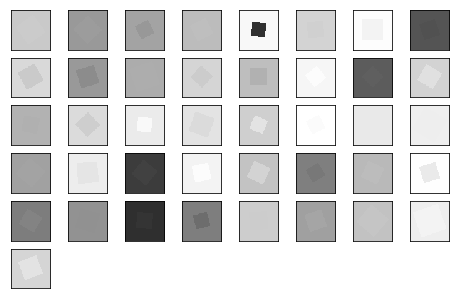

There are  6  triangle shapes in the test set wich have been missclassified.


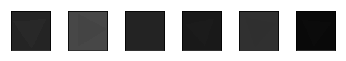

In [85]:
# Split the missclassified images in squares and triangles

# squares
label = 0

squares_wrong = shi.select_shape(images_test_wrong, labels_test_wrong, label)
print('There are ',np.shape(squares_wrong)[0] , ' square shapes in the test set wich have been missclassified.')

# display the first 6 missclassified images 
figsize = (8, 6)
plt.figure(figsize=figsize)
for ind in range(41):
      
    img = squares_wrong[ind].reshape(img_rows, img_cols)
    
    plt.subplot(7, 8, ind+1)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([]) 

plt.show()

# triangles
label = 1

triangles_wrong = shi.select_shape(images_test_wrong, labels_test_wrong, label)
print('There are ',np.shape(triangles_wrong)[0] , ' triangle shapes in the test set wich have been missclassified.')

# display the  missclassified images 
figsize = (8, 6)
plt.figure(figsize=figsize)
for ind in range(6):
      
    img = triangles_wrong[ind].reshape(img_rows, img_cols)
    
    plt.subplot(7, 8, ind+1)
    plt.imshow(img*255,cmap=cm.gray, vmin=0, vmax=255)
    plt.xticks([])
    plt.yticks([]) 

plt.show()

## Analysis

Define a list of top analysis methods by preparing tuples containing the methods' string identifiers used by innvestigate.analyzer.create_analyzer(...), some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render.

In [86]:
# parameters
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(images_test, input_range)
def input_postprocessing(X):
    #return revert_preprocessing(X) / 255
    return 1-X


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME            OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",         {},                       input_postprocessing,      "Input"),


    # Interaction
    ("pattern.attribution",  {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
       
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),

]
    
print('Considered number of explainability methods:', len(methods)-1)

Considered number of explainability methods: 2


The main loop instantiates the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [87]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

path_to_analyzers = "/home/elena/eStep/XAI/Data/TrianglesAndSquaresRotationScale/Analyzers/"  


# Create analyzers.
analyzers = []
for method in methods:
    fname = os.path.join(path_to_analyzers, method[0]+'.npz')
    
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            neuron_selection_mode="index",
                                            **method[1])     
    
    if os.path.isfile(fname) :
        print("Analyzer", method[0], "exists! Loading...")
        analyzer = analyzer.load_npz(fname)

    
    analyzers.append(analyzer)


Analyzer pattern.attribution exists! Loading...


### Analyze correctly classified squares.

Sort the corectly classified squares.

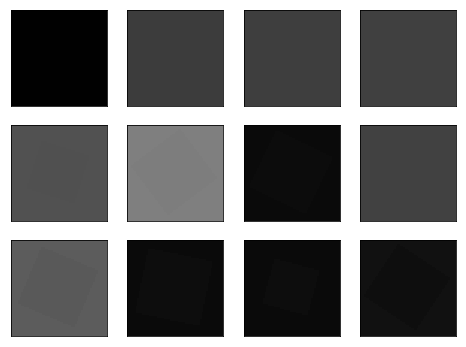

---------------------------------------------


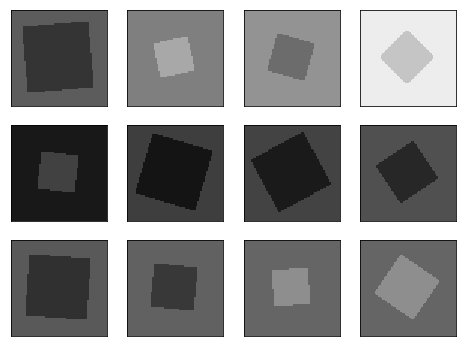

---------------------------------------------


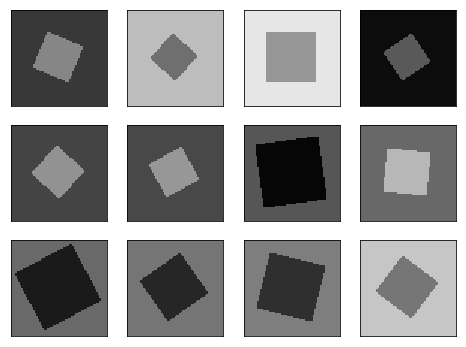

In [88]:
# call sorting function
#sorted_squares_correct, _, _ = shi.sort_size(squares_correct)
sorted_squares_correct, _, _ = shi.sort_contrast(squares_correct)
# plot 12 images after sorting
shi.plot_12seqimages(sorted_squares_correct)
print('---------------------------------------------')
shi.plot_12seqimages(sorted_squares_correct,None, 250)
print('---------------------------------------------')
shi.plot_12seqimages(sorted_squares_correct,None, 500)

--------------------------------------------------------------------------------
Image nr. 5; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

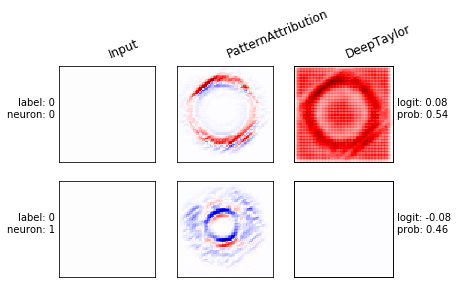

--------------------------------------------------------------------------------
Image nr. 6; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

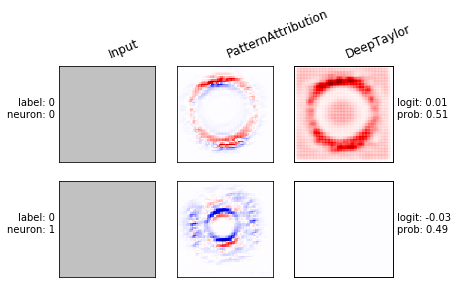

--------------------------------------------------------------------------------
Image nr. 7; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

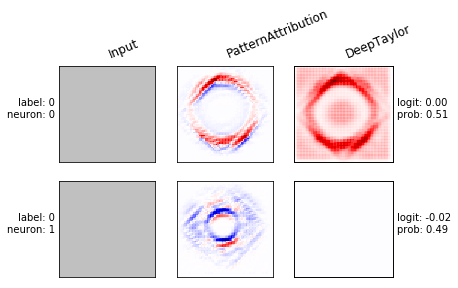

--------------------------------------------------------------------------------
Image nr. 8; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

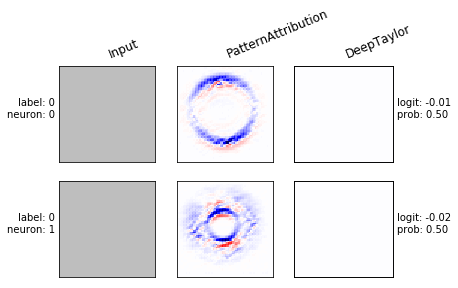

--------------------------------------------------------------------------------
Image nr. 9; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

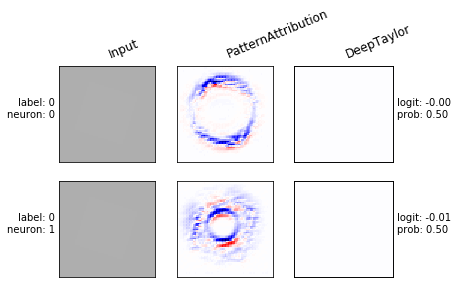

--------------------------------------------------------------------------------
Image nr. 10; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

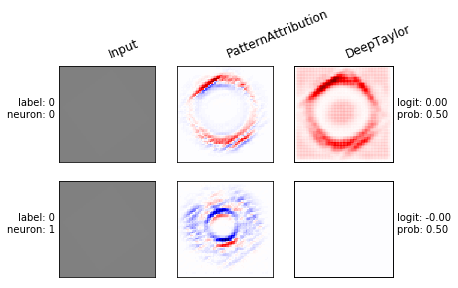

--------------------------------------------------------------------------------
Image nr. 11; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

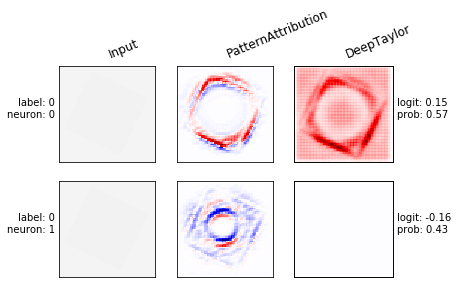

--------------------------------------------------------------------------------
Image nr. 12; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

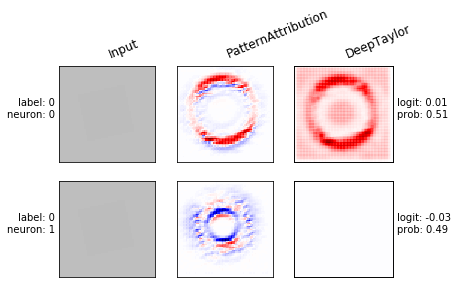

--------------------------------------------------------------------------------
Image nr. 13; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

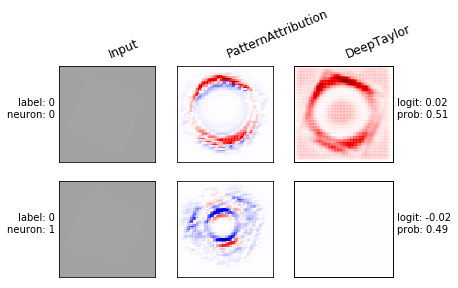

--------------------------------------------------------------------------------
Image nr. 14; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

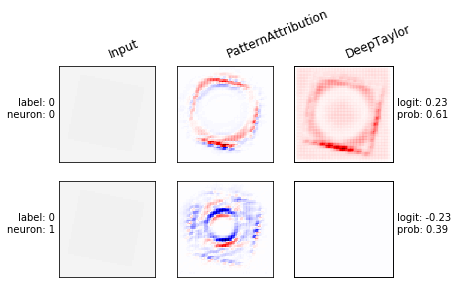

--------------------------------------------------------------------------------
Image nr. 15; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

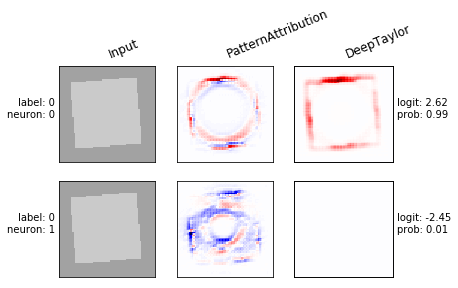

--------------------------------------------------------------------------------
Image nr. 16; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

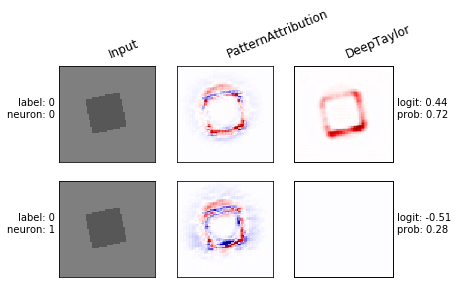

--------------------------------------------------------------------------------
Image nr. 17; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

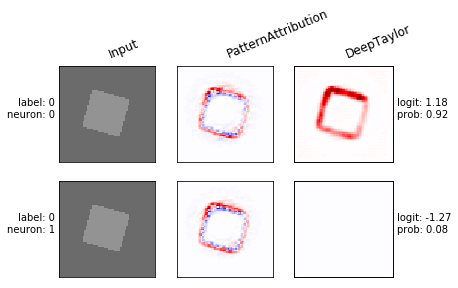

--------------------------------------------------------------------------------
Image nr. 18; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

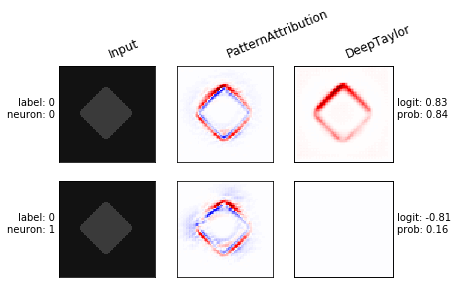

--------------------------------------------------------------------------------
Image nr. 19; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

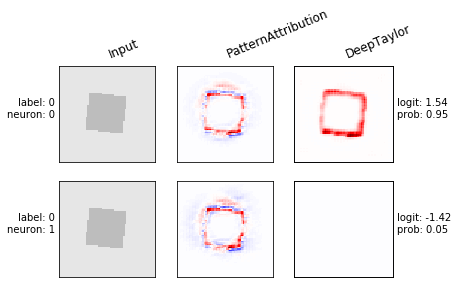

--------------------------------------------------------------------------------
Image nr. 20; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

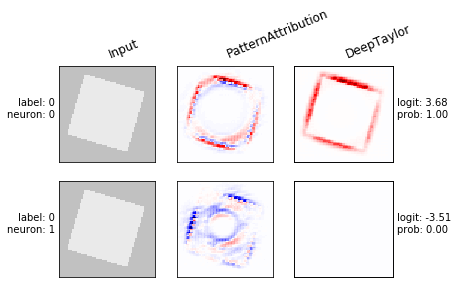

--------------------------------------------------------------------------------
Image nr. 21; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

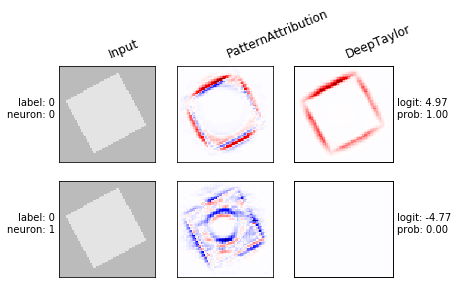

--------------------------------------------------------------------------------
Image nr. 22; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

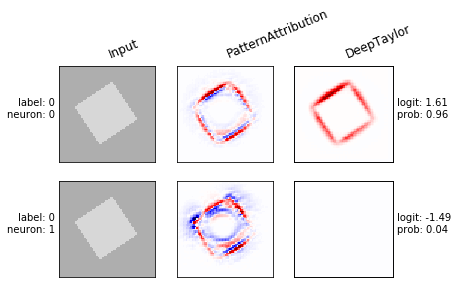

--------------------------------------------------------------------------------
Image nr. 23; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

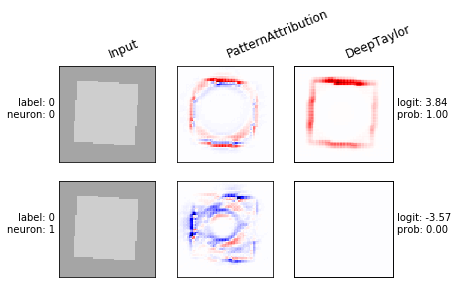

--------------------------------------------------------------------------------
Image nr. 24; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

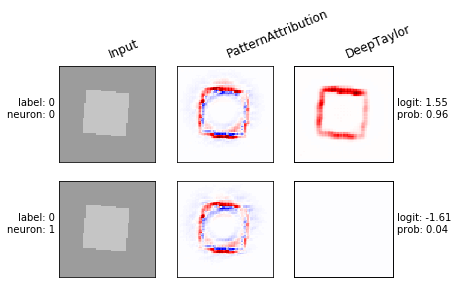

--------------------------------------------------------------------------------
Image nr. 25; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

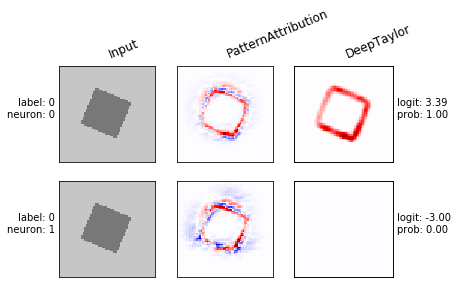

--------------------------------------------------------------------------------
Image nr. 26; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

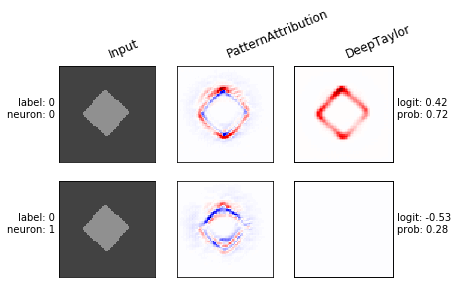

--------------------------------------------------------------------------------
Image nr. 27; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

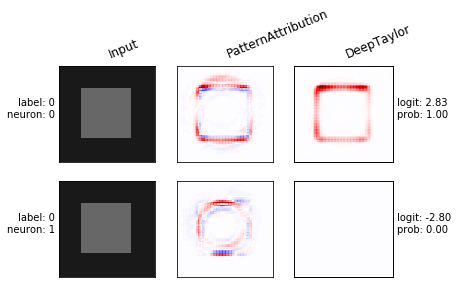

--------------------------------------------------------------------------------
Image nr. 28; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

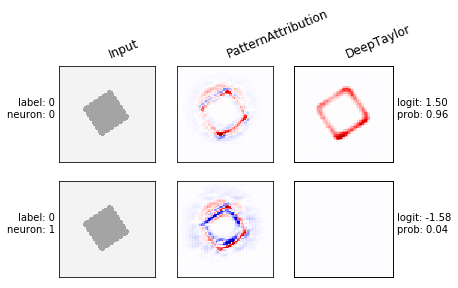

--------------------------------------------------------------------------------
Image nr. 29; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

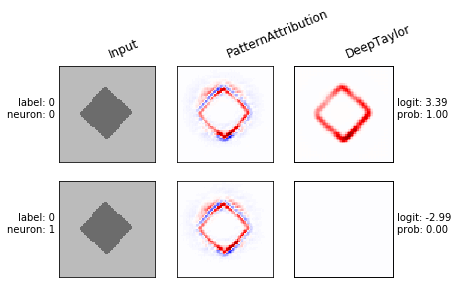

--------------------------------------------------------------------------------
Image nr. 30; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

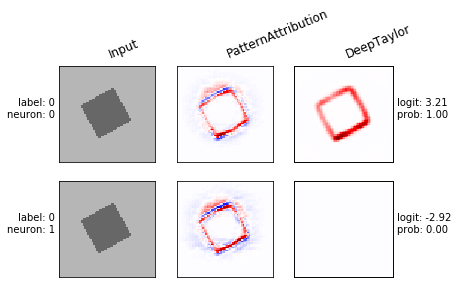

--------------------------------------------------------------------------------
Image nr. 31; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

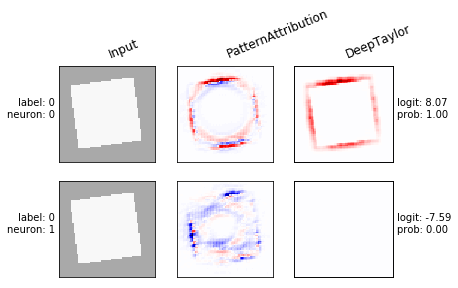

--------------------------------------------------------------------------------
Image nr. 32; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

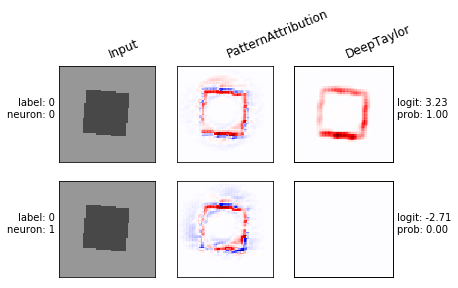

--------------------------------------------------------------------------------
Image nr. 33; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

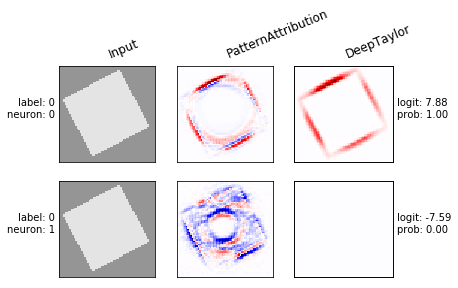

--------------------------------------------------------------------------------
Image nr. 34; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

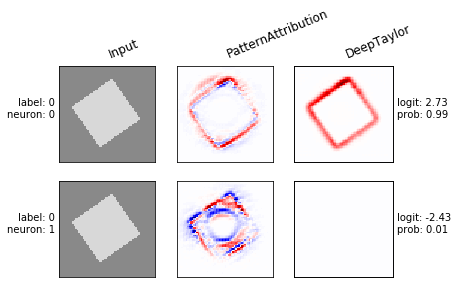

--------------------------------------------------------------------------------
Image nr. 35; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

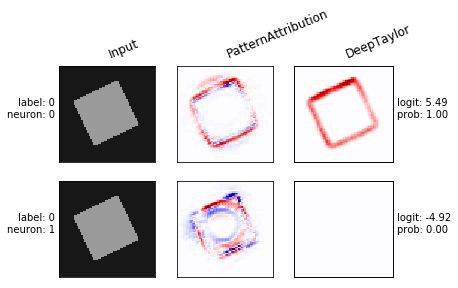

--------------------------------------------------------------------------------
Image nr. 36; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

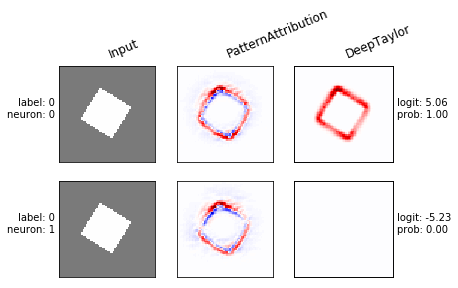

--------------------------------------------------------------------------------
Image nr. 37; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

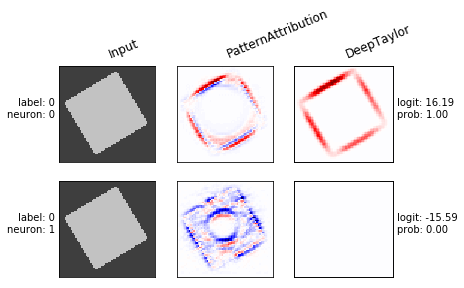

--------------------------------------------------------------------------------
Image nr. 38; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

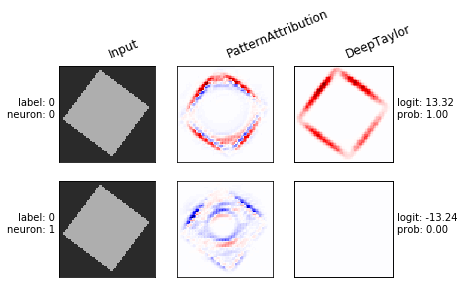

--------------------------------------------------------------------------------
Image nr. 39; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

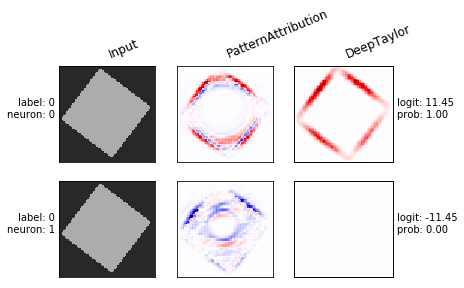

--------------------------------------------------------------------------------
Image nr. 40; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

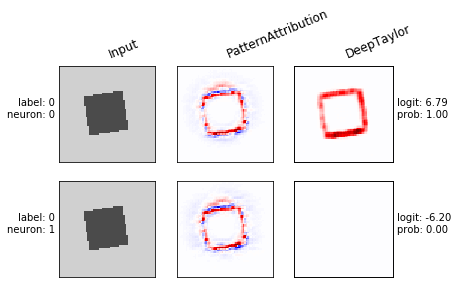

--------------------------------------------------------------------------------
Image nr. 41; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

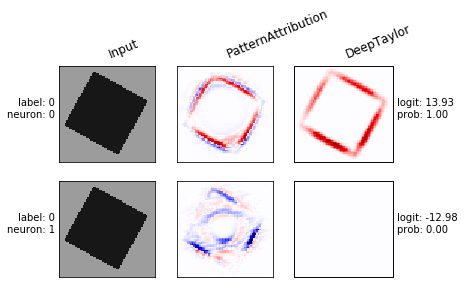

--------------------------------------------------------------------------------
Image nr. 42; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

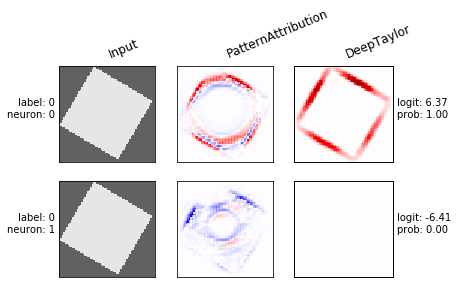

--------------------------------------------------------------------------------
Image nr. 43; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

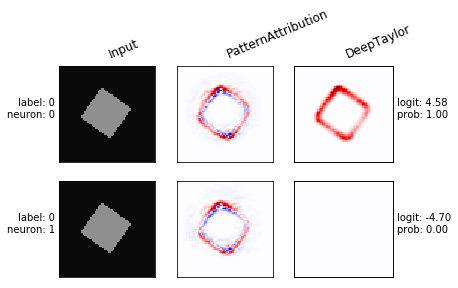

--------------------------------------------------------------------------------
Image nr. 44; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

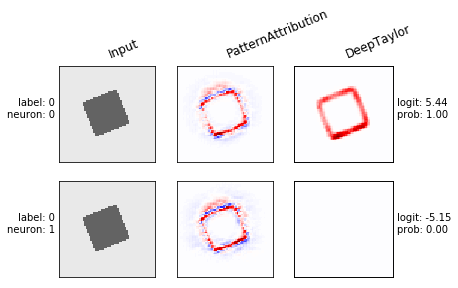

--------------------------------------------------------------------------------
Image nr. 45; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

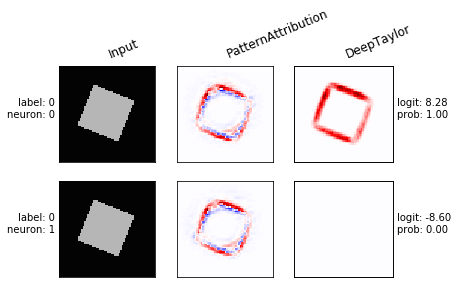

--------------------------------------------------------------------------------
Image nr. 46; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

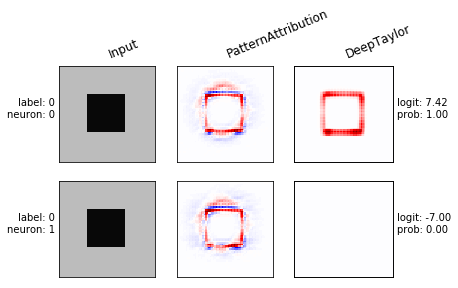

--------------------------------------------------------------------------------
Image nr. 47; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

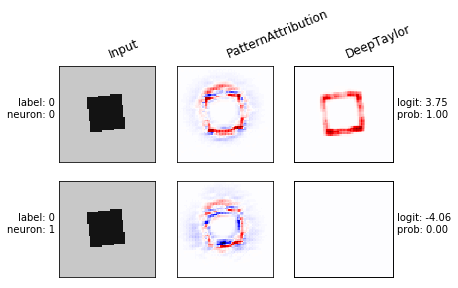

--------------------------------------------------------------------------------
Image nr. 48; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

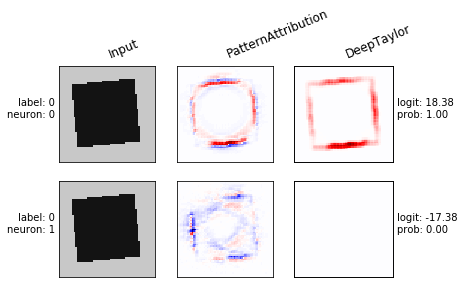

--------------------------------------------------------------------------------
Image nr. 49; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

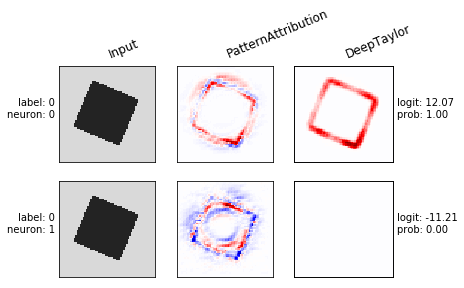

--------------------------------------------------------------------------------
Image nr. 50; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

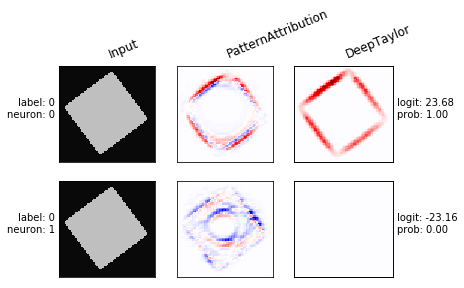

--------------------------------------------------------------------------------
Image nr. 51; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

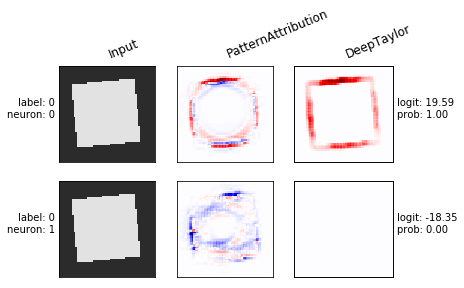

--------------------------------------------------------------------------------
Image nr. 52; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

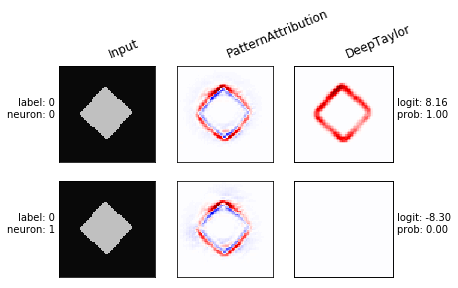

--------------------------------------------------------------------------------
Image nr. 53; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

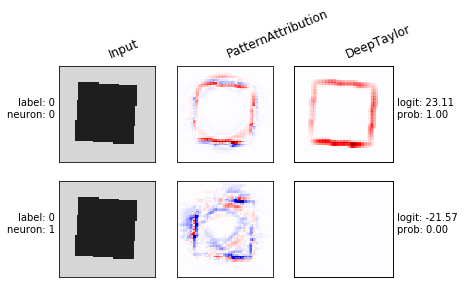

--------------------------------------------------------------------------------
Image nr. 54; prediction: 0 
('0', '0')


<Figure size 432x288 with 0 Axes>

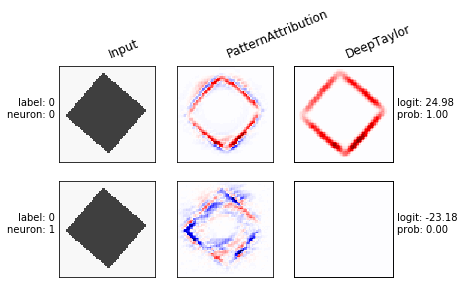

In [89]:
nim = np.shape(squares_correct)[0]
ntim = 10
indices1 = range(0,ntim)
indices2 = range(250,250+ntim)
indices3 = range(500,500+ntim)
indices4 = range(750,750+ntim)
indices5 = range(900,900+ntim)

indices = np.concatenate([indices1, indices2, indices3, indices4, indices5])
num_classes = 2
labels = np.zeros(nim)

test_images = list(zip(sorted_squares_correct[indices], labels))

label_to_class_name = [str(i) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    y = int(y)
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
   # row_labels_right = []
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
   # print(file_name)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)

### Analyze correctly classified triangles.

Sort the corectly classified triangles.

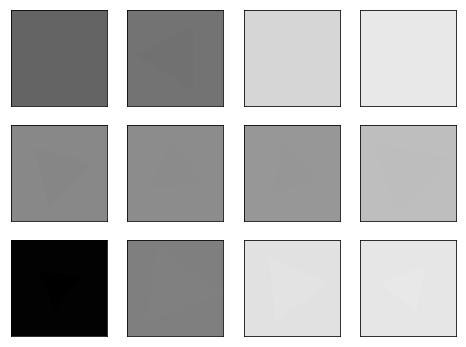

---------------------------------------------


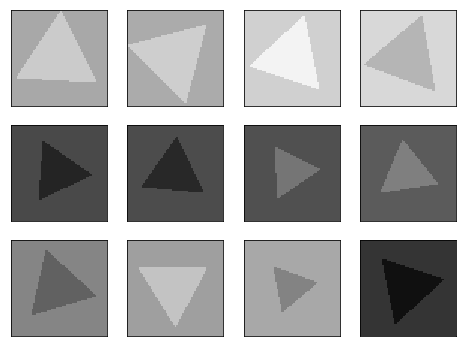

---------------------------------------------


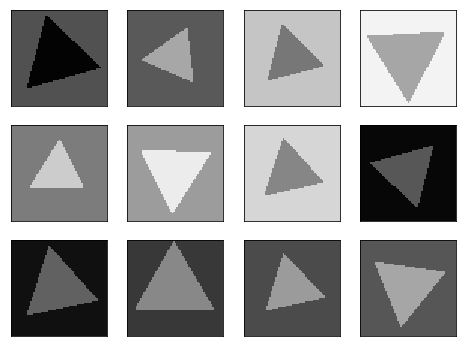

In [90]:
# call sorting function
#sorted_triangles_correct, _, _ = shi.sort_size(triangles_correct)
sorted_triangles_correct, _, _ = shi.sort_contrast(triangles_correct)
# plot 12 images after sorting
shi.plot_12seqimages(sorted_triangles_correct)
print('---------------------------------------------')
shi.plot_12seqimages(sorted_triangles_correct,None, 250)
print('---------------------------------------------')
shi.plot_12seqimages(sorted_triangles_correct,None, 500)

--------------------------------------------------------------------------------
Image nr. 5; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

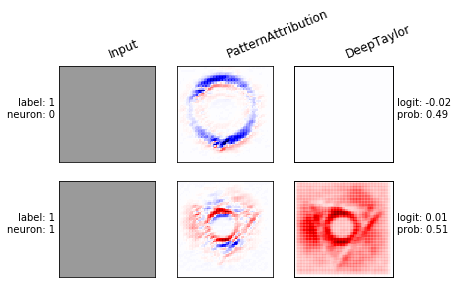

--------------------------------------------------------------------------------
Image nr. 6; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

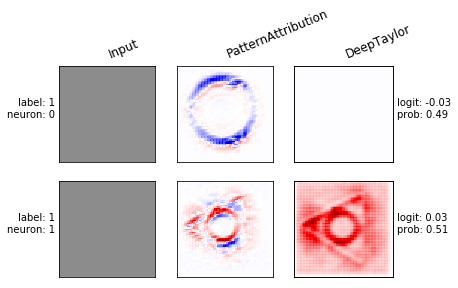

--------------------------------------------------------------------------------
Image nr. 7; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

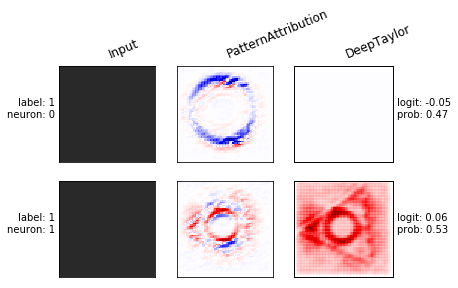

--------------------------------------------------------------------------------
Image nr. 8; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

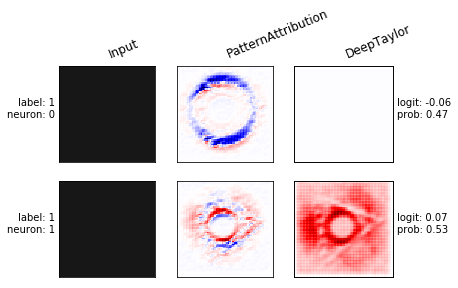

--------------------------------------------------------------------------------
Image nr. 9; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

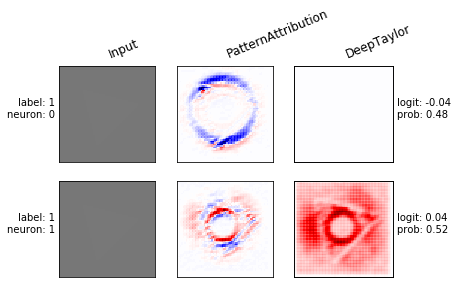

--------------------------------------------------------------------------------
Image nr. 10; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

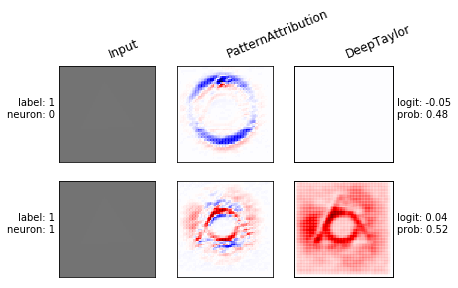

--------------------------------------------------------------------------------
Image nr. 11; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

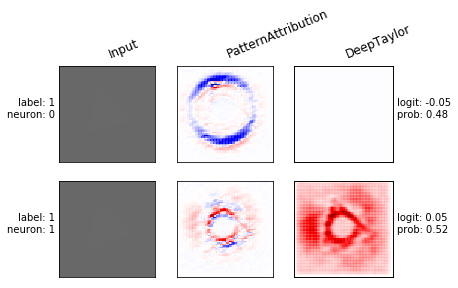

--------------------------------------------------------------------------------
Image nr. 12; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

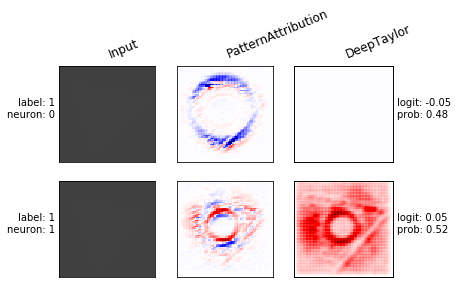

--------------------------------------------------------------------------------
Image nr. 13; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

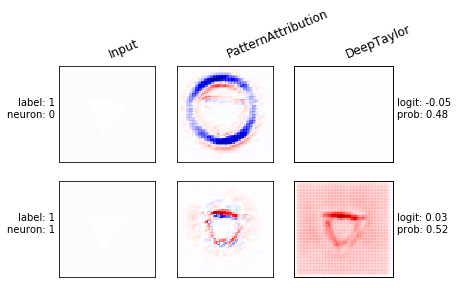

--------------------------------------------------------------------------------
Image nr. 14; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

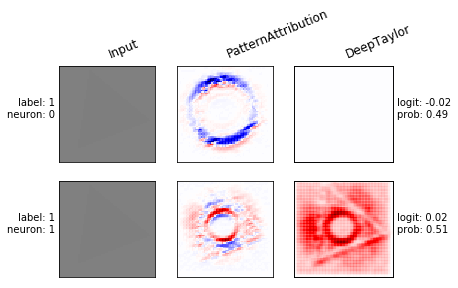

--------------------------------------------------------------------------------
Image nr. 15; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

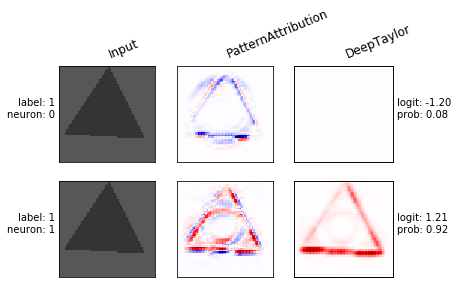

--------------------------------------------------------------------------------
Image nr. 16; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

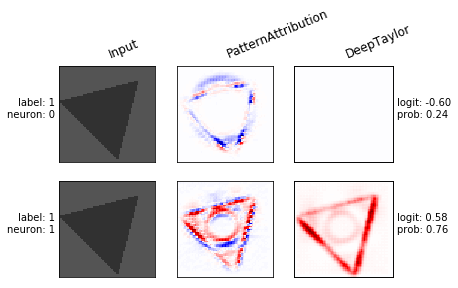

--------------------------------------------------------------------------------
Image nr. 17; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

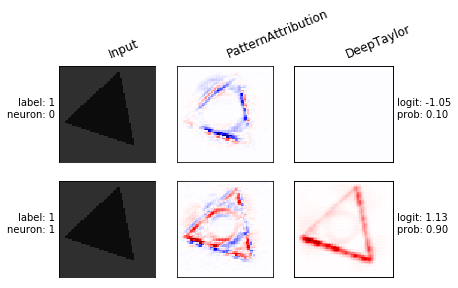

--------------------------------------------------------------------------------
Image nr. 18; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

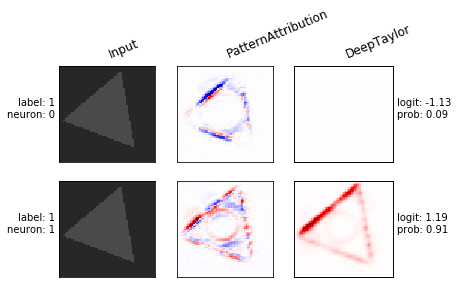

--------------------------------------------------------------------------------
Image nr. 19; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

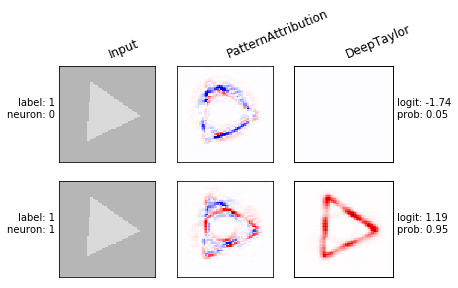

--------------------------------------------------------------------------------
Image nr. 20; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

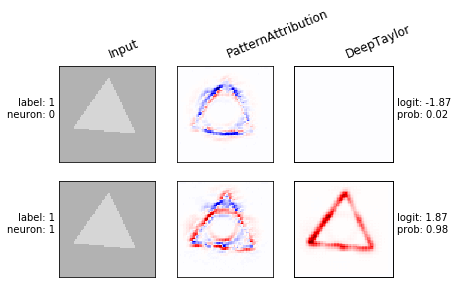

--------------------------------------------------------------------------------
Image nr. 21; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

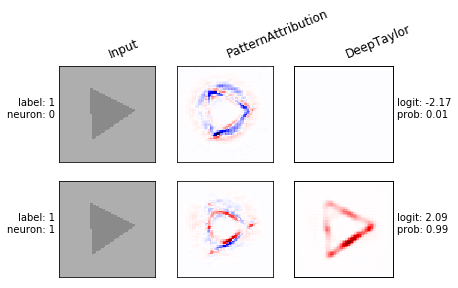

--------------------------------------------------------------------------------
Image nr. 22; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

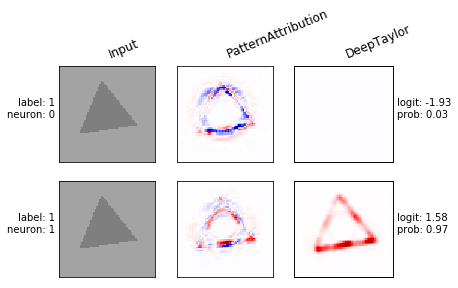

--------------------------------------------------------------------------------
Image nr. 23; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

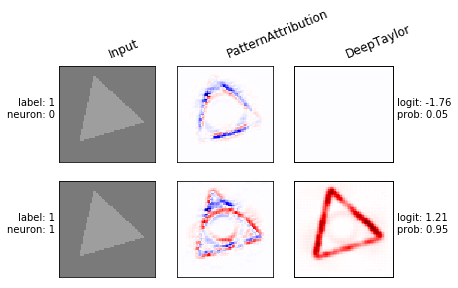

--------------------------------------------------------------------------------
Image nr. 24; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

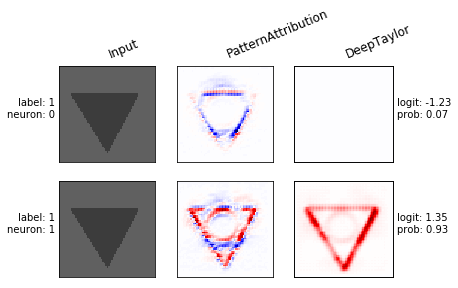

--------------------------------------------------------------------------------
Image nr. 25; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

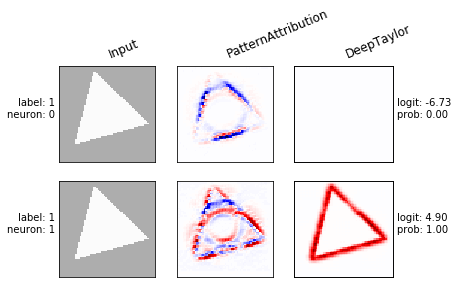

--------------------------------------------------------------------------------
Image nr. 26; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

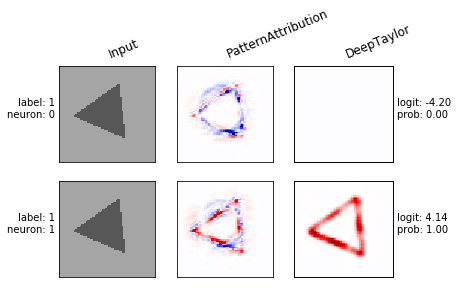

--------------------------------------------------------------------------------
Image nr. 27; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

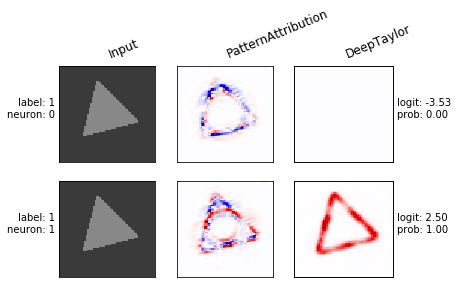

--------------------------------------------------------------------------------
Image nr. 28; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

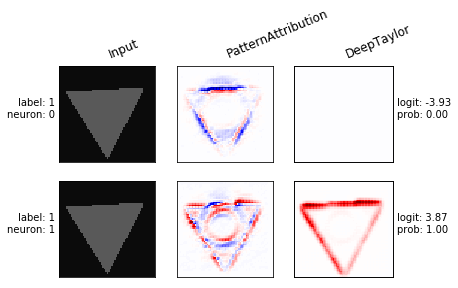

--------------------------------------------------------------------------------
Image nr. 29; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

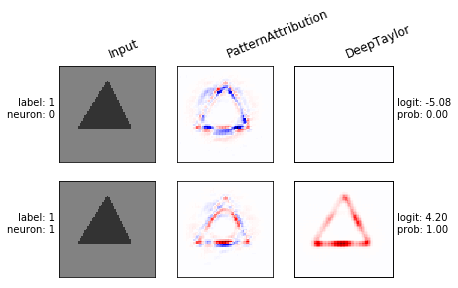

--------------------------------------------------------------------------------
Image nr. 30; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

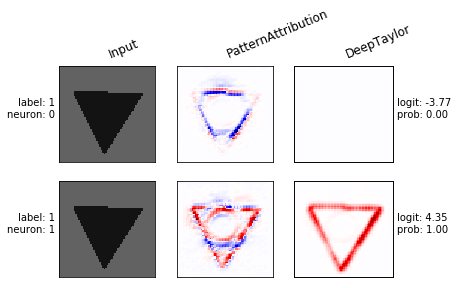

--------------------------------------------------------------------------------
Image nr. 31; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

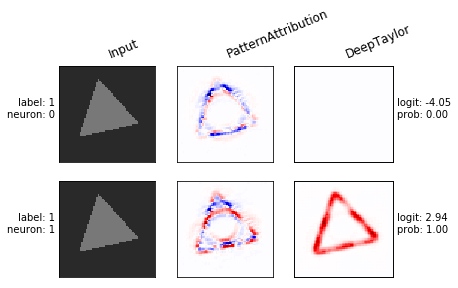

--------------------------------------------------------------------------------
Image nr. 32; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

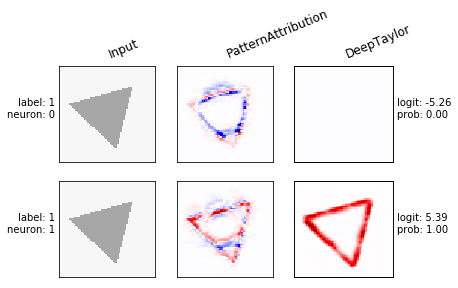

--------------------------------------------------------------------------------
Image nr. 33; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

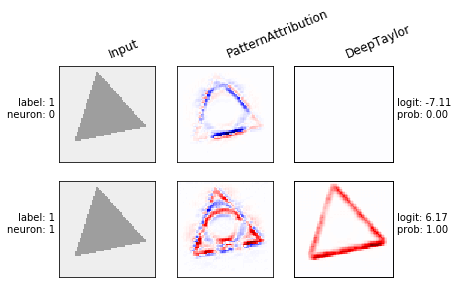

--------------------------------------------------------------------------------
Image nr. 34; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

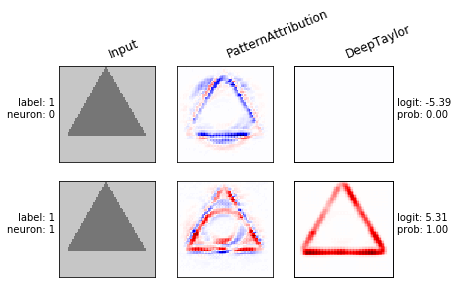

--------------------------------------------------------------------------------
Image nr. 35; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

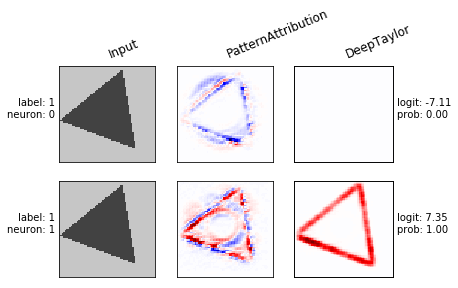

--------------------------------------------------------------------------------
Image nr. 36; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

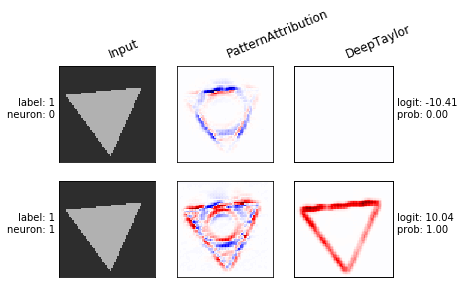

--------------------------------------------------------------------------------
Image nr. 37; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

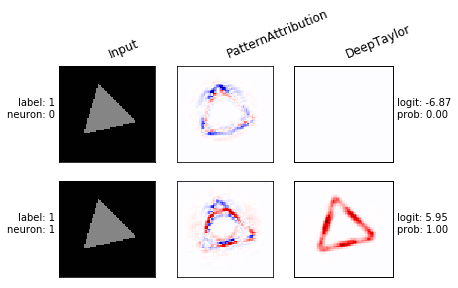

--------------------------------------------------------------------------------
Image nr. 38; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

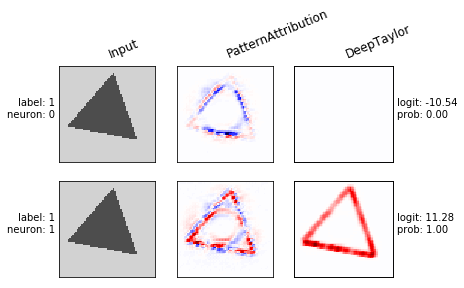

--------------------------------------------------------------------------------
Image nr. 39; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

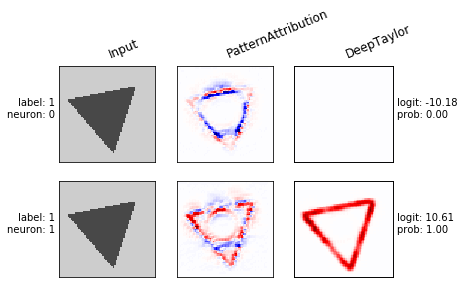

--------------------------------------------------------------------------------
Image nr. 40; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

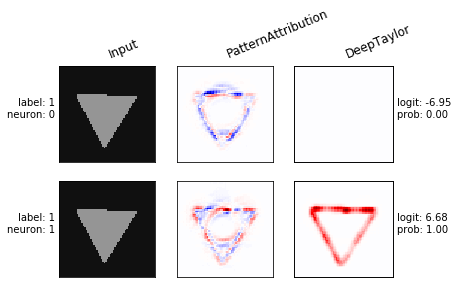

--------------------------------------------------------------------------------
Image nr. 41; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

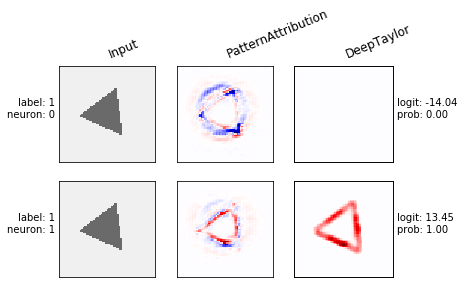

--------------------------------------------------------------------------------
Image nr. 42; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

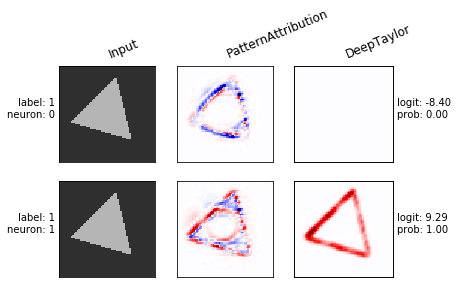

--------------------------------------------------------------------------------
Image nr. 43; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

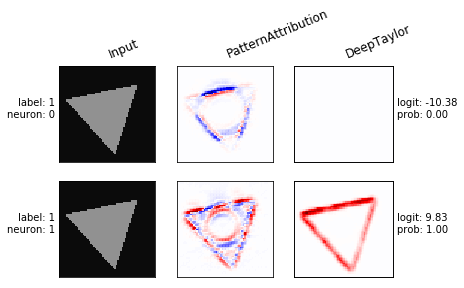

--------------------------------------------------------------------------------
Image nr. 44; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

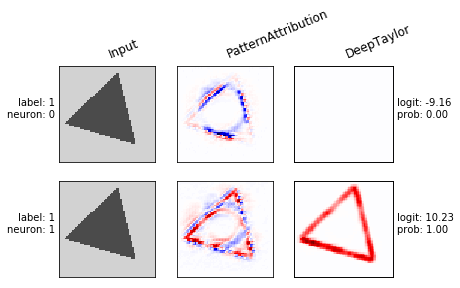

--------------------------------------------------------------------------------
Image nr. 45; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

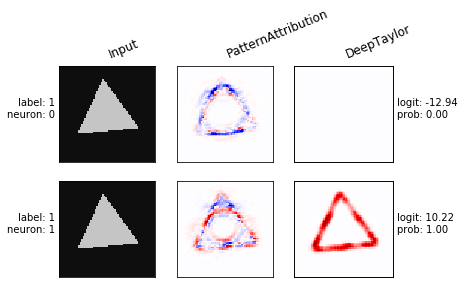

--------------------------------------------------------------------------------
Image nr. 46; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

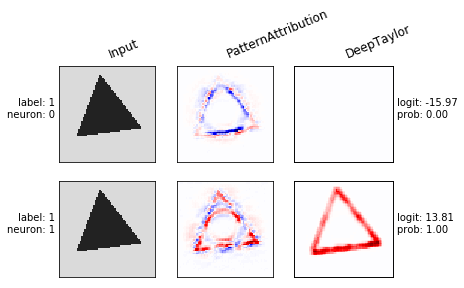

--------------------------------------------------------------------------------
Image nr. 47; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

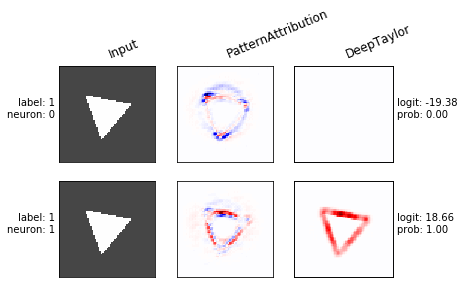

--------------------------------------------------------------------------------
Image nr. 48; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

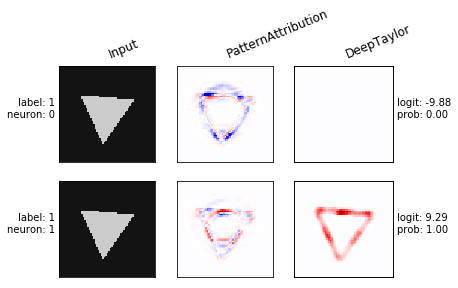

--------------------------------------------------------------------------------
Image nr. 49; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

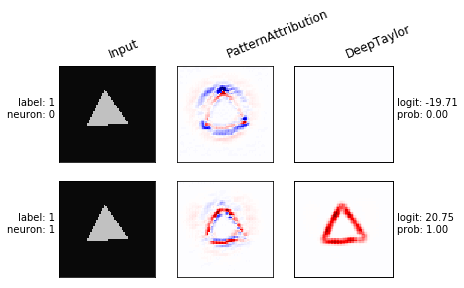

--------------------------------------------------------------------------------
Image nr. 50; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

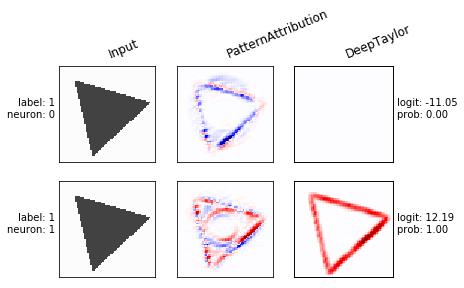

--------------------------------------------------------------------------------
Image nr. 51; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

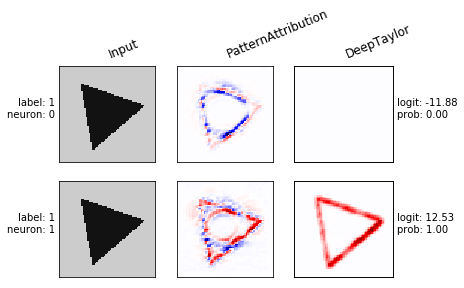

--------------------------------------------------------------------------------
Image nr. 52; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

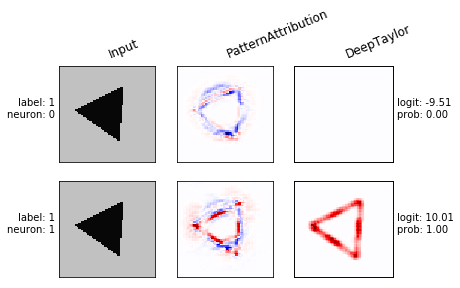

--------------------------------------------------------------------------------
Image nr. 53; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

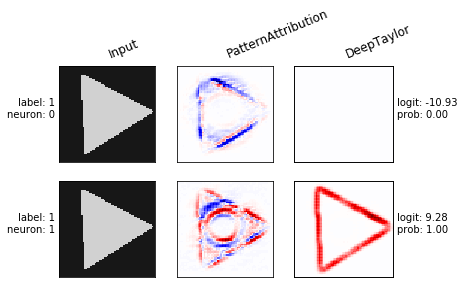

--------------------------------------------------------------------------------
Image nr. 54; prediction: 1 
('1', '1')


<Figure size 432x288 with 0 Axes>

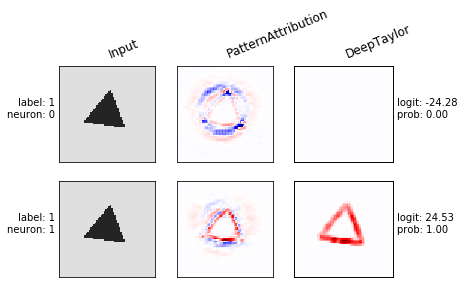

In [91]:
nim = np.shape(triangles_correct)[0]
ntim = 10
indices1 = range(0,ntim)
indices2 = range(250,250+ntim)
indices3 = range(500,500+ntim)
indices4 = range(750,750+ntim)
indices5 = range(900,900+ntim)

indices = np.concatenate([indices1, indices2, indices3, indices4, indices5])
num_classes = 2
labels = np.ones(nim)

test_images = list(zip(sorted_triangles_correct[indices], labels))

label_to_class_name = [str(i) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    y = int(y)
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
   # row_labels_right = []
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
   # print(file_name)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)